In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:

def create_frequency_grid(size):
    """Create a 2D frequency grid centered at (size//2, size//2)."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2)
    return D, X, Y

def create_1d_profile(size):
    """Create 1D frequency profile."""
    return np.linspace(0, size//2, size//2)

def ideal_lowpass(D, D0):
    """Ideal lowpass filter response."""
    return (D <= D0).astype(float)

def butterworth_lowpass(D, D0, n):
    """Butterworth lowpass filter response."""
    return 1 / (1 + (D / D0)**(2 * n))

def gaussian_lowpass(D, D0):
    """Gaussian lowpass filter response."""
    return np.exp(-(D**2) / (2 * D0**2))

def plot_comprehensive_view(D0, n_butterworth, filter_type='All'):
    """Create comprehensive visualization with 1D, 3D and magnitude plots."""
    # Create frequency grids
    size = 100
    D_2d, X, Y = create_frequency_grid(size)
    D_1d = create_1d_profile(size)

    # Calculate filter responses
    filters = {}
    if filter_type in ['All', 'Ideal']:
        filters['Ideal'] = ideal_lowpass(D_2d, D0)
    if filter_type in ['All', 'Butterworth']:
        filters['Butterworth'] = butterworth_lowpass(D_2d, D0, n_butterworth)
    if filter_type in ['All', 'Gaussian']:
        filters['Gaussian'] = gaussian_lowpass(D_2d, D0)

    # Create subplots
    n_filters = len(filters)
    fig = plt.figure(figsize=(5*n_filters, 12))

    # Plot for each filter
    for idx, (name, response) in enumerate(filters.items()):
        # 1D Profile
        ax1 = fig.add_subplot(3, n_filters, idx + 1)
        ax1.plot(D_1d, response[size//2, size//2:], linewidth=2)
        ax1.set_title(f'{name} Filter 1D Profile')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Response')
        ax1.grid(True)

        # 3D Surface
        ax2 = fig.add_subplot(3, n_filters, idx + 1 + n_filters, projection='3d')
        surf = ax2.plot_surface(X, Y, response, cmap='viridis')
        ax2.set_title(f'{name} Filter 3D Surface')
        ax2.set_xlabel('u')
        ax2.set_ylabel('v')
        ax2.set_zlabel('H(u,v)')

        # Magnitude Image
        ax3 = fig.add_subplot(3, n_filters, idx + 1 + 2*n_filters)
        im = ax3.imshow(response, cmap='viridis')
        ax3.set_title(f'{name} Filter Magnitude')
        plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

def apply_filter_to_array(img, D0=30, n_butterworth=2):
    """Apply all filters to a numpy array image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)  # Convert to grayscale

    # Get centered FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    # Create frequency grid
    rows, cols = img.shape
    D, _, _ = create_frequency_grid(rows)

    # Create filters
    filters = {
        'Ideal': ideal_lowpass(D, D0),
        'Butterworth': butterworth_lowpass(D, D0, n_butterworth),
        'Gaussian': gaussian_lowpass(D, D0)
    }

    # Apply filters
    filtered_images = {}
    filtered_spectrums = {}
    for name, filt in filters.items():
        filtered_shift = fshift * filt
        filtered_images[name] = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))
        filtered_spectrums[name] = np.log(np.abs(filtered_shift) + 1)

    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Original image and spectrum
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(magnitude_spectrum, cmap='gray')
    axes[1,0].set_title('Original Spectrum')

    # Filtered images and spectrums
    for idx, (name, filtered) in enumerate(filtered_images.items(), 1):
        axes[0,idx].imshow(filtered_images[name], cmap='gray')
        axes[0,idx].set_title(f'{name} Filtered')
        axes[1,idx].imshow(filtered_spectrums[name], cmap='gray')
        axes[1,idx].set_title(f'{name} Spectrum')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [3]:
# Create interactive widget for filter visualization
interact(
    plot_comprehensive_view,
    D0=widgets.IntSlider(
        value=20,
        min=1,
        max=50,
        step=1,
        description='D₀:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    ),
    filter_type=widgets.Dropdown(
        options=['All', 'Ideal', 'Butterworth', 'Gaussian'],
        description='Filter:',
        value='All'
    )
)



interactive(children=(IntSlider(value=20, continuous_update=False, description='D₀:', max=50, min=1), IntSlide…

<function __main__.plot_comprehensive_view(D0, n_butterworth, filter_type='All')>

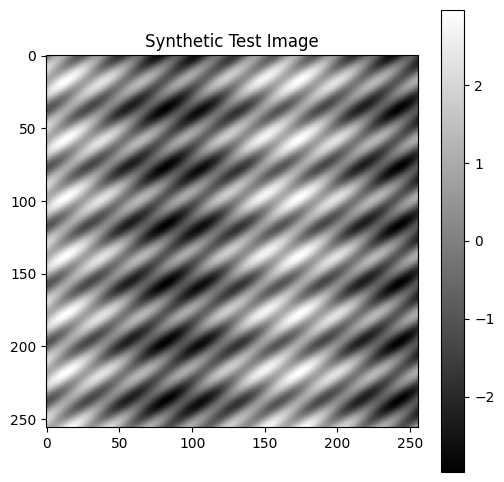

In [4]:
# Create synthetic test image
def create_test_image(size=256):
    """Create a synthetic test image with various frequency components."""
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Create pattern with different frequency components
    image = np.sin(0.5*X) + np.sin(2*Y) + np.sin(3*X + 4*Y)
    return image

# Generate and display test image
test_image = create_test_image()
plt.figure(figsize=(6, 6))
plt.imshow(test_image, cmap='gray')
plt.title('Synthetic Test Image')
plt.colorbar()
plt.show()



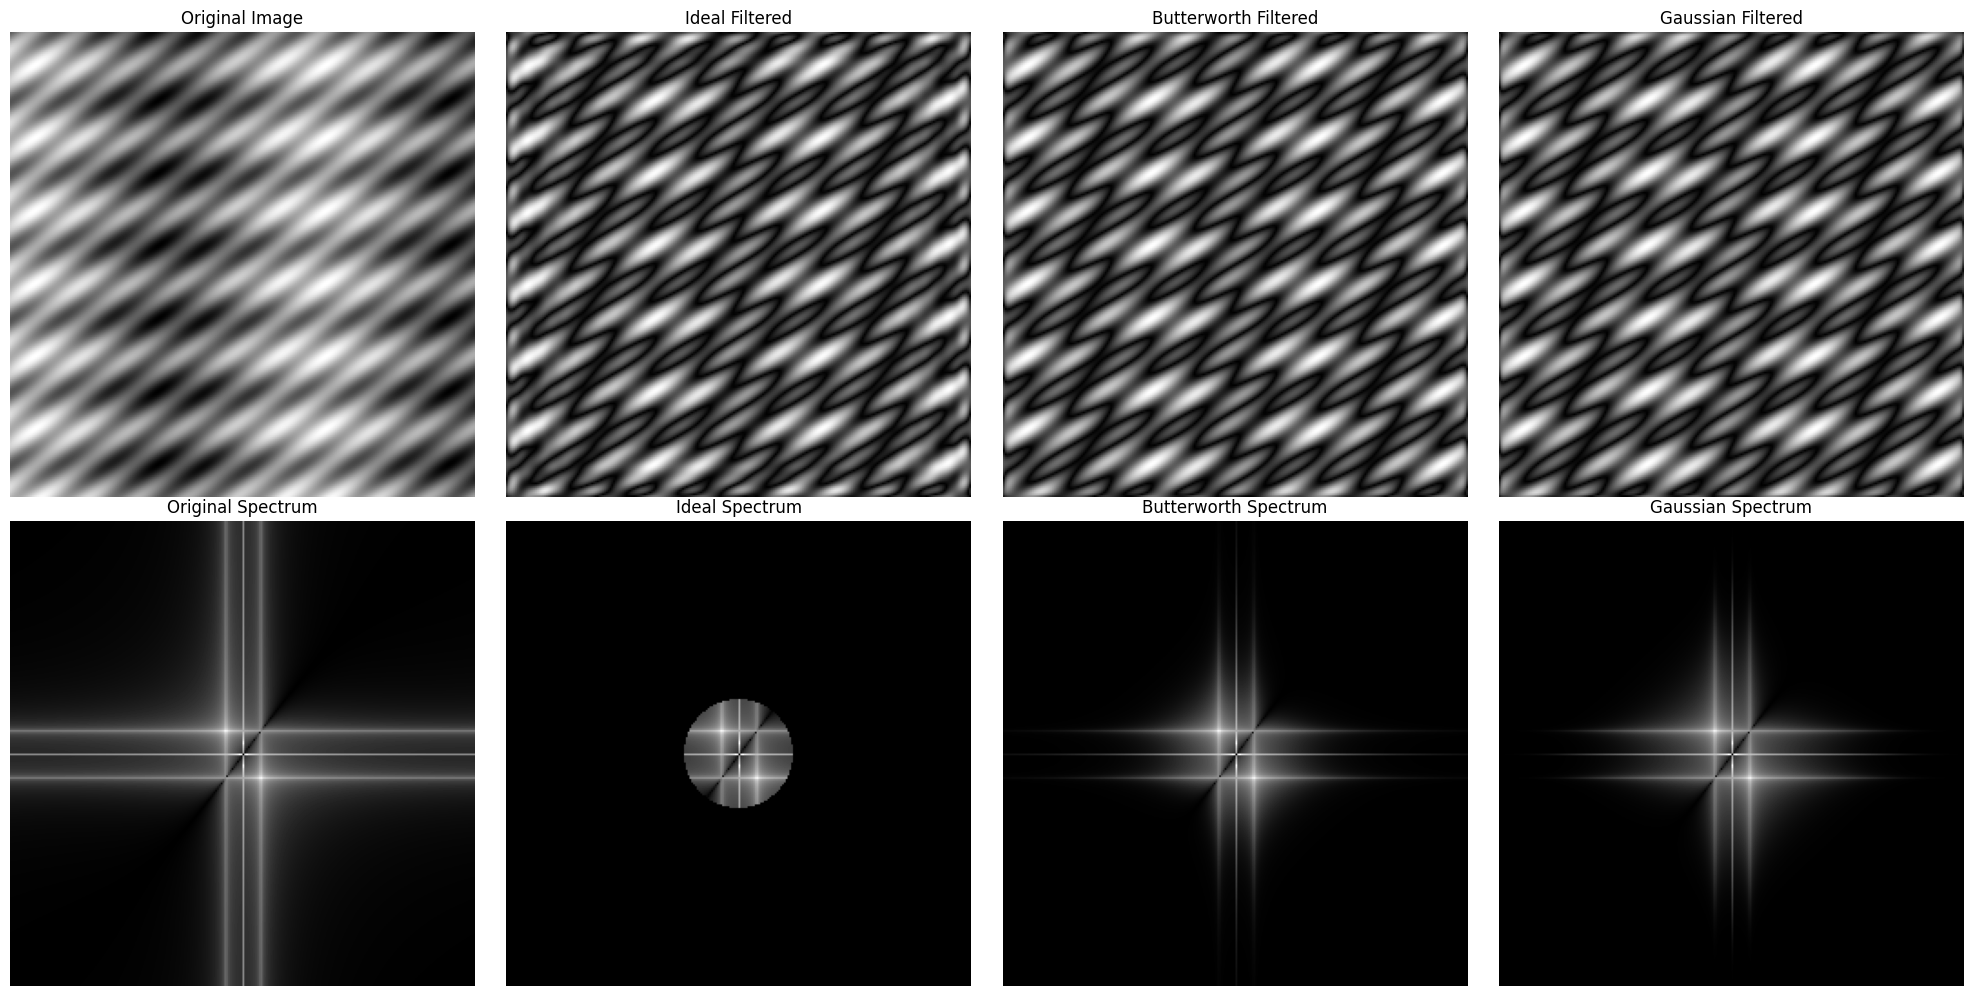

In [5]:
# Apply filters to test image
apply_filter_to_array(test_image, D0=30, n_butterworth=2)



In [6]:
# Create interactive widget for image filtering
interact(
    apply_filter_to_array,
    img=fixed(test_image),
    D0=widgets.IntSlider(
        value=30,
        min=1,
        max=100,
        step=1,
        description='D₀:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    )
)


interactive(children=(IntSlider(value=30, continuous_update=False, description='D₀:', min=1), IntSlider(value=…

<function __main__.apply_filter_to_array(img, D0=30, n_butterworth=2)>